## Visualization

In [3]:
import sys
sys.path.append("..")

import os
import argparse
import torch
import umap.umap_ as umap
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colormaps

base_path = "/workspace/dev/NumericalNet"
model_path = os.path.join(base_path, "outputs/20240526_test_v2", 'best_model.pth')
model = torch.load(model_path)
device = model.device
model = model.to(device)

In [4]:
def apply_umap(embeddings, n_components=2):
    n_neighbors = min(15, len(embeddings) - 1)
    umap_model = umap.UMAP(n_components=n_components, n_neighbors=n_neighbors)
    reduced = umap_model.fit_transform(embeddings)
    return reduced

def plot_embeddings(embeddings_2d, labels, label_texts, title, colors, output_path, plot_type='scatter', extra_text=None, figsize=(8, 6)):
    
    plt.figure(figsize=figsize)
    
    if plot_type == 'scatter':
        # Scatter plot with groups
        unique_labels = np.unique(labels)
        for label, color, text in zip(unique_labels, colors, label_texts):
            mask = labels == label
            plt.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1], color=color, label=text)
    elif plot_type == 'text':
        # Scatter plot with text annotations
        plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], color=colors, marker='o', s=150)
        if extra_text:
            for i in range(len(extra_text)):
                plt.text(embeddings_2d[i, 0] + 0.05, embeddings_2d[i, 1] + 0.05, extra_text[i], fontsize=12)

    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')
    plt.title(title)
    plt.legend(loc='upper left', bbox_to_anchor=(1,1)) if plot_type == 'scatter' else None
    plt.grid(True)
    plt.tight_layout()
    
    if output_path is not None:
        plt.savefig(output_path, bbox_inches='tight')

    plt.show()

## Digit Embeddings Plot

In [5]:
def get_digit_range(start, end, step, device):
    numeric_range = [[np.round(x, 4)] for x in np.arange(start, end, step)]
    numeric_range = torch.tensor(numeric_range, dtype=torch.float32).to(device)
    return numeric_range

def get_digit_embeddings(model, start=0, end=10, step=0.1):
    numeric_range = get_digit_range(start, end, step, model.device)
    with torch.no_grad():
        numeric_embeddings = model.get_digit_embedding(numeric_range)

    numeric_embeddings = numeric_embeddings.squeeze(1)
    return numeric_embeddings.cpu().numpy()

In [35]:
ranges = [
    (0, 10, 0.1),
    (10, 20, 0.1),
    (20, 30, 0.1),
    (30, 40, 0.1),
    (40, 50, 0.1),
    (100, 200, 1),
    (200, 300, 1),
    (300, 400, 1),
    (400, 500, 1),
    (1000, 2000, 10),
    (2000, 3000, 10),
    (3000, 4000, 10),
    (4000, 5000, 10)
]

digit_embeddings = [get_digit_embeddings(model, start, end, step) for start, end, step in ranges]
digit_labels = [np.ones(len(x))*idx for idx, x in enumerate(digit_embeddings)]
digit_labels_text = [f'{x[0]} to {x[1]}' for x in ranges]

In [36]:
print(digit_embeddings[0].shape)
print(digit_labels[0])
print(digit_labels_text)

(100, 512)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
['0 to 10', '10 to 20', '20 to 30', '30 to 40', '40 to 50', '100 to 200', '200 to 300', '300 to 400', '400 to 500', '1000 to 2000', '2000 to 3000', '3000 to 4000', '4000 to 5000']


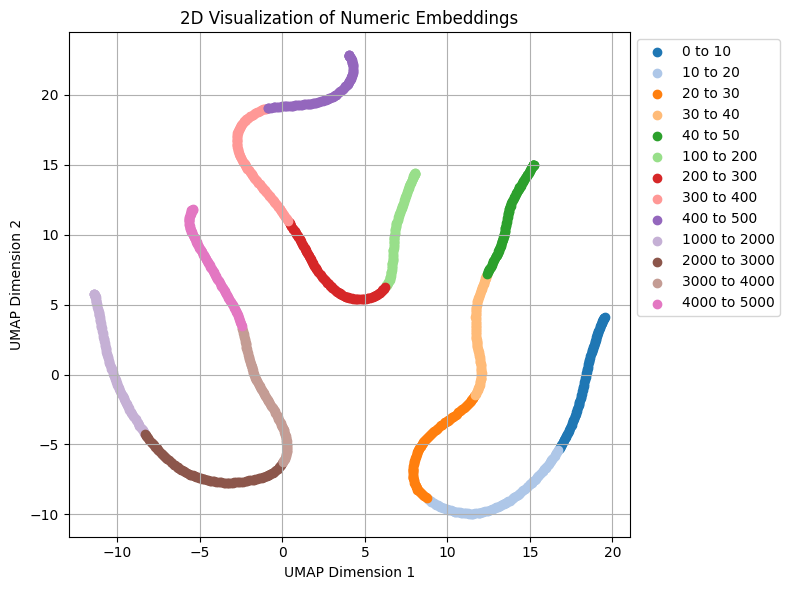

In [37]:
def plot_digit_embeddings(embeddings, labels, labels_text, output_path=None, title="2D Visualization of Numeric Embeddings", cmap='tab20'):

    concat_embeddings = np.concatenate(embeddings)
    embeddings_2d = apply_umap(concat_embeddings)

    concat_labels = np.concatenate(labels)

    # Generate colors for each range
    cmap = colormaps[cmap]
    colors = [cmap(i) for i in range(len(labels_text))]

    # Draw Plots    
    output_fn = os.path.join(output_path, "digit_embedding.png") if output_path is not None else None    
    plot_embeddings(embeddings_2d, concat_labels, labels_text, title, colors, output_fn)

plot_digit_embeddings(
    digit_embeddings,
    digit_labels,
    digit_labels_text,
    title="2D Visualization of Numeric Embeddings"
)

## Unit Embeddings Plot

In [9]:
def get_target_units(unit_list, unit_value_dict, device):
    target_units = [[unit_value_dict[unit]] for unit in unit_list]
    target_units = torch.tensor(target_units, dtype=torch.float32).to(device)
    return target_units

def get_unit_embeddings(unit_list, model, device):
    target_units = get_target_units(unit_list, model.unit_value_dict, device)
    model.eval()
    with torch.no_grad():
        unit_embeddings = model.get_unit_embedding(target_units)
    unit_embeddings = unit_embeddings.squeeze(1)
    return unit_embeddings.cpu()

In [10]:
def plot_unit_embeddings(unit_list, model, output_path=None, title="2D Visualization of Unit Embedding"):
    unit_embeddings = get_unit_embeddings(unit_list, model, model.device)
    unit_embeddings_2d = apply_umap(unit_embeddings)

    colors, texts = [], []
    for unit in unit_list:
        texts.append(unit)
        if unit in ["kg", "g", "mg"]:
            colors.append("purple")
        elif unit in ["ml", "l"]:
            colors.append("orange")
        elif unit in ["cm", "km", "mm", "m"]:
            colors.append("pink")
    
    # Draw Plots
    output_fn = os.path.join(output_path, "unit_embedding.png") if output_path is not None else None    
    plot_embeddings(unit_embeddings_2d, None, None, title, colors, output_fn, 'text', texts)

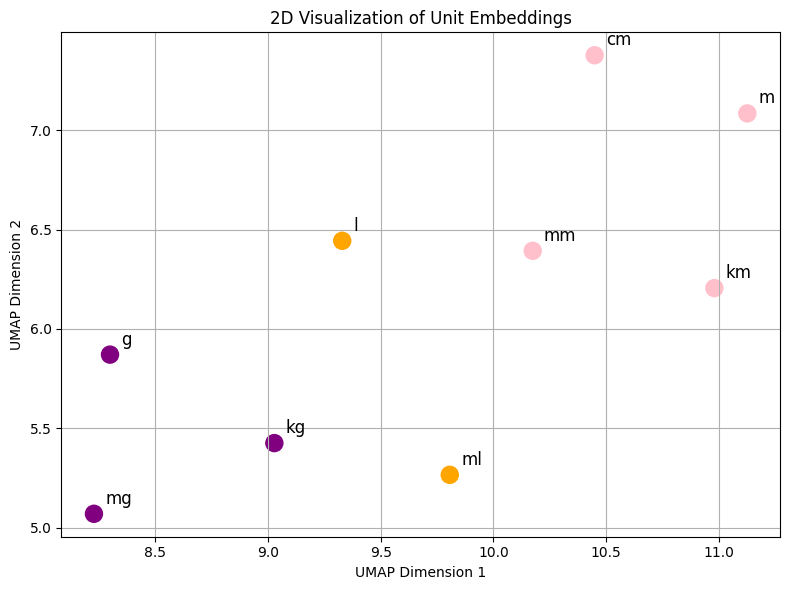

In [11]:
# get unit embeddings
units= ['g', 'mg', 'kg', 'ml', 'l', 'cm', 'km', 'mm', 'm']
plot_unit_embeddings(
    units,
    model,
    title="2D Visualization of Unit Embeddings"
)

## Joint Embeddings Plot

In [16]:
def get_joint_embeddings(digits, units, model):
    model.eval()
    with torch.no_grad():
        joint_embedding = model.get_joint_embedding(digits, units)
    return joint_embedding.cpu()

In [12]:
def plot_joint_embeddings(embeddings, labels, labels_text, output_path=None, title="2D Visualization of Numeric w/ Digit Embeddings", cmap='tab20', advanced=False):

    concat_embeddings = np.concatenate(embeddings)
    embeddings_2d = apply_umap(concat_embeddings)
    concat_labels = np.concatenate(labels)

    # Generate colors for each range
    cmap = colormaps[cmap]
    colors = [cmap(i) for i in range(len(labels_text))] 

    # Draw Plots
    output_fn_temp = "joint_embedding.png" if not advanced else "advanced_joint_embedding.png"
    output_fn = os.path.join(output_path, output_fn_temp) if output_path is not None else None
    plot_embeddings(embeddings_2d, concat_labels, labels_text, title, colors, output_fn, 'scatter')

In [13]:
# get numerical embeddings
digit_unit_ranges = [
    ("kg", 0, 10, 0.1),
    ("kg", 10, 20, 0.1),
    ("ml", 0, 10, 0.1),
    ("ml", 10, 30, 0.2),
    ("m", 2, 22, 0.2),
    ("m", 22, 42, 0.2),
]

joint_embeddings, joint_labels = [], []
for idx, (unit, start, end, step) in enumerate(digit_unit_ranges):
    temp_digit_range = get_digit_range(start, end, step, model.device)
    
    units = [unit]*len(temp_digit_range)
    temp_target_units = get_target_units(units, model.unit_to_idx, model.device)
    temp_joint_embedding = get_joint_embeddings(temp_digit_range, temp_target_units, model)

    joint_embeddings.append(temp_joint_embedding)
    joint_labels.append(np.ones(len(temp_digit_range))*idx)
    
label_texts = [f'{x[1]}{x[0]} to {x[2]}{x[0]}' for x in digit_unit_ranges]

In [14]:
print(joint_embeddings[0].shape)
print(joint_labels[0])
print(label_texts)

torch.Size([100, 512])
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
['0kg to 10kg', '10kg to 20kg', '0ml to 10ml', '10ml to 30ml', '2m to 22m', '22m to 42m']


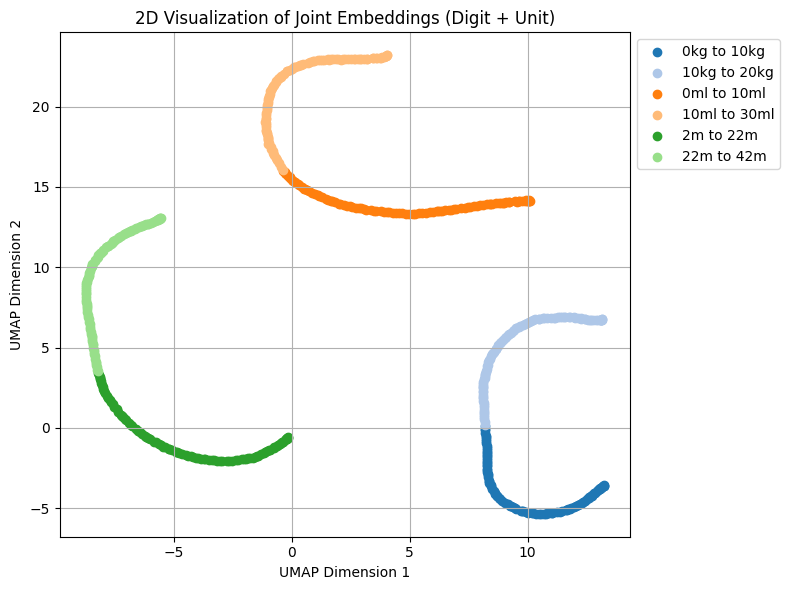

In [15]:
plot_joint_embeddings(
    joint_embeddings, 
    joint_labels,
    label_texts,
    title="2D Visualization of Joint Embeddings (Digit + Unit)"
)